In [1]:
import os,sys
import numpy as np
import torch
import matplotlib.pyplot as plt
# import glob

In [410]:
dtype = torch.float64
device = torch.device("cpu")

In [3]:
# import library for simulating Poisson point processes
dirP_str = os.path.join(os.environ['HOME'], 
                    'Documents',
                    'GitHub',
                    'deadtime-sim-ptv',
                    'python',
                    'library')
if dirP_str not in sys.path:
    sys.path.append(dirP_str)
    
import sim_deadtime_utils as sim

# Generate Simulated Data

In [516]:
# simulation resolution settings
t_sim_min = 0
t_sim_max = 1e-6
dt_sim = 1e-12

tD = 200e-9 # deadtime
Nshot = 500 # number of laser shots
wrap_deadtime = True  # wrap deadtime between shots

laser_pulse_width = 20e-9 # laser pulse width in seconds
target_time = 700e-9
target_amplitude = 5e6 # target peak count rate
background = 1e4  # background count rate

In [517]:
# generate the simulated scene time axis
t_sim = np.arange(t_sim_min,t_sim_max,dt_sim)           # simulation time
t_sim_bins = np.concatenate((t_sim,t_sim[-1:]+dt_sim))  # simulation time histogram bins

In [518]:
# generate the photon arrival rate of the profile
# Gaussian target with constant background
photon_rate_arr = target_amplitude*np.exp(-(t_sim - target_time)**2/(2*laser_pulse_width**2))+background

In [519]:
# generate photon counts

# lists of photon arrivals per
# laser shot
t_det_lst = []  # detected photons (includes deadtime)
t_phot_lst = [] # actual photons (no dead time)

t_det_last = -100.0  # last photon detection event
for n in range(Nshot):
    # simulate a laser shot
    ptime,ctime = sim.photon_count_generator(t_sim_bins, 
                                            photon_rate_arr, 
                                            tau_d_flt=tD,
                                            last_photon_flt=t_det_last)
    if wrap_deadtime:
        if len(ctime) > 0:
            t_det_last = ctime[-1]
        t_det_last -= t_sim_bins[-1]
        
    t_det_lst += [ctime]  # detection time tags (including deadtime)
    t_phot_lst += [ptime] # photon time tags

Text(0.5, 1.0, 'Detected Photons')

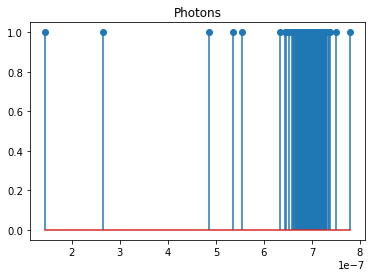

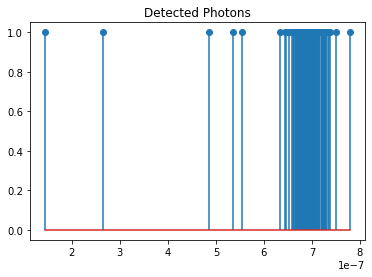

In [520]:
phot_arr = np.array(sorted(np.concatenate(t_phot_lst)))
plt.figure()
plt.stem(phot_arr,np.ones(phot_arr.size))
plt.title('Photons')


cnt_arr = np.array(sorted(np.concatenate(t_det_lst)))
plt.figure()
plt.stem(cnt_arr,np.ones(cnt_arr.size))
plt.title('Detected Photons')

In [521]:
# split data into fit and validation sets
split_index = int(len(t_phot_lst)//2)
cnt_phot_fit = len(t_phot_lst[:split_index])
cnt_phot_val = len(t_phot_lst[:split_index])
t_phot_fit = np.concatenate(t_phot_lst[:split_index])
t_phot_val = np.concatenate(t_phot_lst[split_index:])

Double check the integral approximation using erf()

In [522]:
t_torch = torch.tensor(t_sim)
integral_est = torch.tensor(t_sim*background) \
        + 0.5*target_amplitude*laser_pulse_width*np.sqrt(2*np.pi) \
        + 0.5*target_amplitude*laser_pulse_width*np.sqrt(2*np.pi)\
            *torch.special.erf((t_torch-target_time)/(laser_pulse_width*np.sqrt(2)))

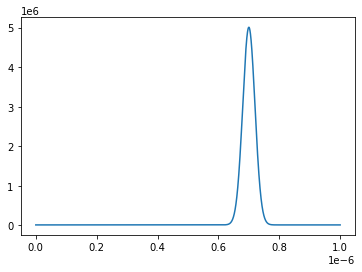

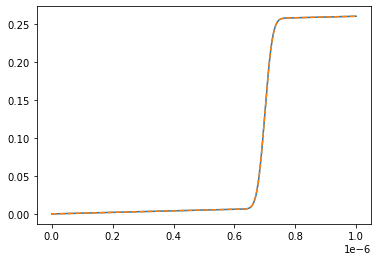

In [523]:
plt.figure()
plt.plot(t_sim,photon_rate_arr)

plt.figure()
plt.plot(t_sim,np.cumsum(photon_rate_arr)*dt_sim)
plt.plot(t_sim,integral_est.numpy(),'--')

# Perform Fit Using PyTorch
Assume the target is described by a Gaussian with a constant background

In [537]:
# convert training and validation data to 
# tensor type
t_phot_fit_tnsr = torch.tensor(t_phot_fit)
t_phot_val_tnsr = torch.tensor(t_phot_val)

In [538]:
class Fit_Pulse(torch.nn.Module):
    def __init__(self,t_max):
        """
        Instantiate and initialize the fit parameters.
        """
        super().__init__()
        self.log_A = torch.nn.Parameter(5*torch.ones(()))   # Gaussian amplitude
        self.log_mu = torch.nn.Parameter(-9*torch.ones(()))  # Gaussian mean
        self.log_sig = torch.nn.Parameter(-9*torch.ones(())) # Gaussian std
        self.log_b = torch.nn.Parameter(3*torch.ones(()))      # background
        self.t_max = t_max # maximum time evaluated in integral term
        
        self.sqrt_2pi = torch.sqrt(torch.tensor(2*np.pi))
        self.sqrt_2  = torch.sqrt(torch.tensor(2.0))
        

    def forward(self, t):
        """
        Forward model the profile for input time t
        """
        
        
        A = torch.exp(self.log_A)
        mu = torch.exp(self.log_mu)
        sig = torch.exp(self.log_sig)
        b = torch.exp(self.log_b)
        
        
        model_out = A*torch.exp(-(t-mu)**2/(2*sig**2)) + b
        
        integral_out = b*self.t_max \
                        + 0.5*A*sig*self.sqrt_2pi \
                        + 0.5*A*sig*self.sqrt_2pi\
                            *torch.special.erf((self.t_max-mu)/(sig*self.sqrt_2))
        return model_out, integral_out

In [539]:
def pois_loss(prof,integral):
    return integral-torch.sum(torch.log(prof))

In [540]:
rel_step_lim = 1e-15
max_epochs = 5000
learning_rate = 1e-1
term_persist = 20

In [541]:
fit_model = Fit_Pulse(t_sim[-1])
optimizer = torch.optim.Adam(fit_model.parameters(),lr=learning_rate)
epoch=0
rel_step = 1e3*rel_step_lim
train_loss_lst = []
valid_loss_lst = []
rel_step_lst = []

In [542]:
loss_fn = pois_loss

In [543]:
while rel_step > rel_step_lim and epoch < max_epochs:
    fit_model.train()
    pred,integral = fit_model(t_phot_fit_tnsr)
    loss = loss_fn(pred,integral*cnt_phot_fit)  # add regularization here
    train_loss_lst +=[loss.item()]

    if epoch == 0:
        rel_step_lst+=[1e3*rel_step_lim]
        rel_step = 1e3*rel_step_lim
    else:
        rel_step_lst+=[(train_loss_lst[-2]-train_loss_lst[-1])/np.abs(train_loss_lst[-2])]
        rel_step = np.abs(np.array(rel_step_lst)[-term_persist:].mean())
    
    # calculate validation loss... for fun
    pred_val,integral_val = fit_model(t_phot_val_tnsr)
    loss_val = loss_fn(pred_val,integral_val*cnt_phot_val)
    valid_loss_lst +=[loss_val.item()]

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

#     print(f"{train_loss_lst[-1]}")
    
    epoch+=1
    
#     sol_lst += [{'cos_coef':fit_model.cos_coef,
#               'sin_coef':fit_model.sin_coef,
#               'dc':fit_model.dc}]
#     val_loss_lst +=[loss_fn(pred*cnt_vld,y_vld).item()]
#     trn_lst_sets+=[train_loss_lst]
#     trn_rel_step_lst+=[rel_step_lst]
#         print(f"{l1_reg}: {val_loss_lst[-1]}, {epoch} iterations")

In [544]:
pred_val,integral_val = fit_model(t_phot_val_tnsr)
loss_val = loss_fn(pred_val,integral_val*cnt_phot_val)
print(f"Validation Loss: {loss_val}")

Validation Loss: -962.4580878017837


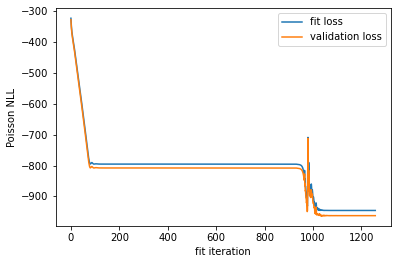

In [545]:
plt.figure()
plt.plot(train_loss_lst,label='fit loss')
plt.plot(valid_loss_lst,label='validation loss')
plt.xlabel('fit iteration')
plt.ylabel('Poisson NLL')
plt.legend()

Display the resulting estimate

In [546]:
pred_mod_full,integral_full = fit_model(torch.tensor(t_sim))

Text(0, 0.5, 'Photon Arrival Rate [MHz]')

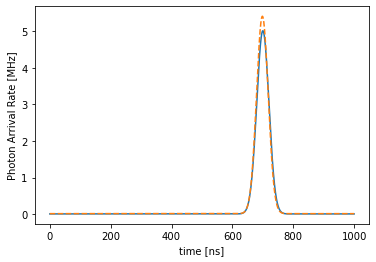

In [547]:
plt.figure()
plt.plot(t_sim*1e9,photon_rate_arr*1e-6,label='Actual')
plt.plot(t_sim*1e9,pred_mod_full.detach().numpy()*1e-6,'--',label='Fit') # /cnt_phot_fit
plt.xlabel('time [ns]')
plt.ylabel('Photon Arrival Rate [MHz]')

In [548]:
pred_mod_fit_pts,integral_fit_pts = fit_model(t_phot_fit_tnsr)
pred_mod_val_pts,integral_val_pts = fit_model(t_phot_val_tnsr)

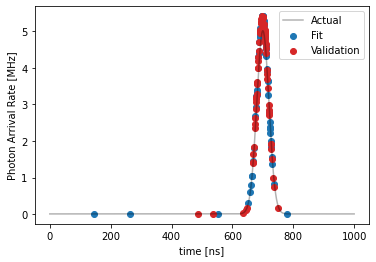

In [549]:
plt.figure()
plt.plot(t_sim*1e9,photon_rate_arr*1e-6,label='Actual',color='k',alpha=0.3)
plt.scatter(t_phot_fit_tnsr.detach().numpy()*1e9,pred_mod_fit_pts.detach().numpy()*1e-6,label='Fit')
plt.scatter(t_phot_val_tnsr.detach().numpy()*1e9,pred_mod_val_pts.detach().numpy()*1e-6,label='Validation',c='tab:red')
plt.xlabel('time [ns]')
plt.ylabel('Photon Arrival Rate [MHz]')
plt.legend()